<a href="https://colab.research.google.com/github/Kartik-Nair/ELG-5142-Project-Group-6/blob/main/Kartik_ELG_5142_Accident_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELG 5142 - Group 06 (Injury Detection)

In this project we are building a binary classification model to predict if an accident leads to injury or no injury.

We are using 2019 Transportation Collision Data collected by the City of Ottawa which is openly available on the following link: https://open.ottawa.ca/datasets/9a91a607e0854bb68371980d29835574_0/explore

We will be analyzing the given dataset and train machine learning models using k-nearest neighbours (KNN) and Decision Tree algorithms, create baseline results and perform data augmentation and feature selection techniques to further improve upon the accuracy of our models.  

# Importing Dataset and Libraries


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from numpy import array

In [2]:
# loading the dataset from github repository and reading it into a data frame using pandas

original_data_directory = "ELG-5142-Project-Group-6/"

if not(os.path.exists(original_data_directory.split("/")[0])):
  !git clone https://github.com/ANISHG-26/ELG-5142-Project-Group-6.git
os.chdir(original_data_directory)

Cloning into 'ELG-5142-Project-Group-6'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 4), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 1007.23 KiB | 8.12 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
data = "2019_Tabular_Transportation_Collision_Data.csv"
df = pd.read_csv(data)

The dataset has 28 columns in total, and each column contains information pertaining to individual accident with details such as the date and time of the accident, location where it took place, traffic conditions, number of pedestrians involved, etc.

In [4]:
df.columns

Index(['Anom_ID', 'Accident_Date', 'Accident_Time', 'Location', 'Geo_ID',
       'Accident_Location', 'Classification_of_Accident',
       'Initial_Impact_Type', 'Environment_Condition', 'Light',
       'Road_Surface_Condition', 'Traffic_Control',
       'Traffic_Control_Condition', 'No__of_Vehicles', 'No__of_Bicycles',
       'No__of_Motorcycles', 'No__of_Pedestrians', 'Max_Injury',
       'No__of_Injuries', 'No__of_Minimal', 'No__of_Minor', 'No__of_Major',
       'No__of_Fatal', 'X', 'Y', 'Latitude', 'Longitude', 'ObjectId'],
      dtype='object')

We can see that there are a few columns with non-null values and few columns have data type other than integer or float. Hence, we will need to check the values present in those columns and will need to drop or transform the values present in those columns for making it possible for our machine learning mmodels to predict accurately.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16399 entries, 0 to 16398
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Anom_ID                     16399 non-null  object 
 1   Accident_Date               16399 non-null  object 
 2   Accident_Time               16399 non-null  object 
 3   Location                    16399 non-null  object 
 4   Geo_ID                      16399 non-null  object 
 5   Accident_Location           16399 non-null  object 
 6   Classification_of_Accident  16399 non-null  object 
 7   Initial_Impact_Type         16399 non-null  object 
 8   Environment_Condition       16399 non-null  object 
 9   Light                       16399 non-null  object 
 10  Road_Surface_Condition      16399 non-null  object 
 11  Traffic_Control             16399 non-null  object 
 12  Traffic_Control_Condition   8735 non-null   object 
 13  No__of_Vehicles             163

Here, we are displaying the first 5 rows in the dataset to better understand the data and the different data types and values present in each column.

In [6]:
df.head(5).T

0  \
Anom_ID                                                             19--10709   
Accident_Date                                                      2019/09/04   
Accident_Time                                                         7:40 AM   
Location                    HWY 417 WALKLEY IC110R57 @ WALKLEY EXTENSION R...   
Geo_ID                                                                   4164   
Accident_Location                                        03 - At intersection   
Classification_of_Accident                                     03 - P.D. only   
Initial_Impact_Type                                                02 - Angle   
Environment_Condition                                               02 - Rain   
Light                                                           01 - Daylight   
Road_Surface_Condition                                               02 - Wet   
Traffic_Control                                                02 - Stop sign   
Traffic_Control_Condition                                    01 - Functioning   
No__of_Vehicles                                                             2   
No__of_Bicycles                                                             0   
No__of_Motorcycles                                                          0   
No__of_Pedestrians                                                          0   
Max_Injury                                                                NaN   
No__of_Injuries                                                             0   
No__of_Minimal                                                            NaN   
No__of_Minor                                                              NaN   
No__of_Major                                                              NaN   
No__of_Fatal                                                              NaN   
X                                                                 375656.9048   
Y                                                                 5028998.541   
Latitude                                                             45.39734   
Longitude                                                          -75.594967   
ObjectId                                                                    1   

                                                                   1  \
Anom_ID                                                    19--10079   
Accident_Date                                             2019/08/19   
Accident_Time                                                9:08 PM   
Location                    GREENBANK RD @ MARKETPLACE AVE (0010406)   
Geo_ID                                                         10406   
Accident_Location                          02 - Intersection related   
Classification_of_Accident                            03 - P.D. only   
Initial_Impact_Type                                    03 - Rear end   
Environment_Condition                                     01 - Clear   
Light                                                      07 - Dark   
Road_Surface_Condition                                      01 - Dry   
Traffic_Control                                  01 - Traffic signal   
Traffic_Control_Condition                           01 - Functioning   
No__of_Vehicles                                                    2   
No__of_Bicycles                                                    0   
No__of_Motorcycles                                                 0   
No__of_Pedestrians                                                 0   
Max_Injury                                                       NaN   
No__of_Injuries                                                    0   
No__of_Minimal                                                   NaN   
No__of_Minor                                                     NaN   
No__of_Major                                                     NaN   
No__of_Fatal                                                     NaN  

From the dataframe description below, we get the count, minimum, maximum and mean values of each column which helps us in determining which columns are useful and which ones can make the model biased. From the table below, we can see that the number of vehicles involved in an accident ranges between 1 to 8. The number of injuries column ranges from 0 to 3.8 and we need to transform this particular column to create a new one which is shown later in the code. There are other columns like the X,Y coordinates and latitude/longitude values which can help the model locate the hotspots which have most number of accidents. We will try to visualize those hotspots while doing our data analysis in the next steps.

In [7]:
df.describe().T

count          mean          std           min  \
No__of_Vehicles     16399.0  1.862736e+00     0.564858  1.000000e+00   
No__of_Bicycles     16399.0  1.811086e-02     0.134268  0.000000e+00   
No__of_Motorcycles  16399.0  8.110251e-03     0.090371  0.000000e+00   
No__of_Pedestrians  16399.0  1.920849e-02     0.142064  0.000000e+00   
No__of_Injuries     16399.0  2.197695e-01     0.634609  0.000000e+00   
No__of_Minimal       1198.0  1.195326e+00     0.579728  1.000000e+00   
No__of_Minor         1575.0  1.276825e+00     0.672241  1.000000e+00   
No__of_Major          108.0  1.240741e+00     1.303270  1.000000e+00   
No__of_Fatal           25.0  1.080000e+00     0.400000  1.000000e+00   
X                   16399.0  3.670292e+05  9339.765281  3.174750e+05   
Y                   16399.0  5.025924e+06  7509.524093  4.981110e+06   
Latitude            16399.0  4.537043e+01     0.067177  4.496798e+01   
Longitude           16399.0 -7.570548e+01     0.119676 -7.633804e+01   
ObjectId            16399.0  8.200000e+03  4734.127868  1.000000e+00   

                             25%           50%           75%           max  
No__of_Vehicles     2.000000e+00  2.000000e+00  2.000000e+00  8.000000e+00  
No__of_Bicycles     0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00  
No__of_Motorcycles  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00  
No__of_Pedestrians  0.000000e+00  0.000000e+00  0.000000e+00  2.000000e+00  
No__of_Injuries     0.000000e+00  0.000000e+00  0.000000e+00  3.800000e+01  
No__of_Minimal      1.000000e+00  1.000000e+00  1.000000e+00  1.100000e+01  
No__of_Minor        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+01  
No__of_Major        1.000000e+00  1.000000e+00  1.000000e+00  1.400000e+01  
No__of_Fatal        1.000000e+00  1.000000e+00  1.000000e+00  3.000000e+00  
X                   3.633117e+05  3.677075e+05  3.716748e+05  4.012228e+05  
Y                   5.022000e+06  5.027184e+06  5.031227e+06  5.043414e+06  
Latitude            4.533547e+01  4.538173e+01  4.541802e+01  4.552470e+01  
Longitude          -7.575278e+01 -7.569635e+01 -7.564629e+01 -7.526894e+01  
ObjectId            4.100500e+03  8.200000e+03  1.229950e+04  1.639900e+04

The below command shows clearly the total number of null values in the columns. As we need to predict whether the accident leads to injury or not, we will be dropping the five columns: Max_injury, No_of_Minimal, No_of_Minor, No_of_Major, No_of_Fatal as they are irrelavant to our prediction.

In [8]:
print(df.isnull().sum())

Anom_ID                           0
Accident_Date                     0
Accident_Time                     0
Location                          0
Geo_ID                            0
Accident_Location                 0
Classification_of_Accident        0
Initial_Impact_Type               0
Environment_Condition             0
Light                             0
Road_Surface_Condition            0
Traffic_Control                   0
Traffic_Control_Condition      7664
No__of_Vehicles                   0
No__of_Bicycles                   0
No__of_Motorcycles                0
No__of_Pedestrians                0
Max_Injury                    13678
No__of_Injuries                   0
No__of_Minimal                15201
No__of_Minor                  14824
No__of_Major                  16291
No__of_Fatal                  16374
X                                 0
Y                                 0
Latitude                          0
Longitude                         0
ObjectId                    

Geo_ID column is another alphanumeric column which has 6072 unique values. These cannot be categorized using label encoding or one hot encoding and cannot be scaled to fit our model, hence we will be dropping this column too.

In [9]:
df.Geo_ID.value_counts()

__3ZA2Y4    61
2237        58
__3ZA2R8    57
12421       48
2707        43
            ..
3716         1
__3ZBNEB     1
__3ZA3KQ     1
11540        1
__3ZA599     1
Name: Geo_ID, Length: 6072, dtype: int64

# Adding Injured Column and dropping Unrelated Columns


For creating our target column 'Injured', we will apply transformation to the 'No_of_Injuries' column to have 'O' for no injury and '1' for any other value of injuries. This will create the target variable for our binary classification task. Once the new column is successfully created, we can drop the old column as it's no longer to be used.

In [10]:
df['Injured'] = df['No__of_Injuries'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
df.drop(['No__of_Injuries'], axis=1, inplace=True)

From the below counts of our new 'Injured' column, we can see that the dataset is imbalanced and the model training will not have good results as the data is highly skewed. As the dataset is small, we will perform oversampling later on to make our model training better.

In [12]:
df.Injured.value_counts()

0    13678
1     2721
Name: Injured, dtype: int64

# Visualizing Injuries based on Road Surface Condition

Surprisingly, the number of injuries are highest in dry conditions compared to other conditions. Very few people got injured in snowy or wet conditions, which could mean that the injuries in dry condition are higher as there are more chances of overspeeding compared to other conditions where we are more wary of our speed and surroundings.

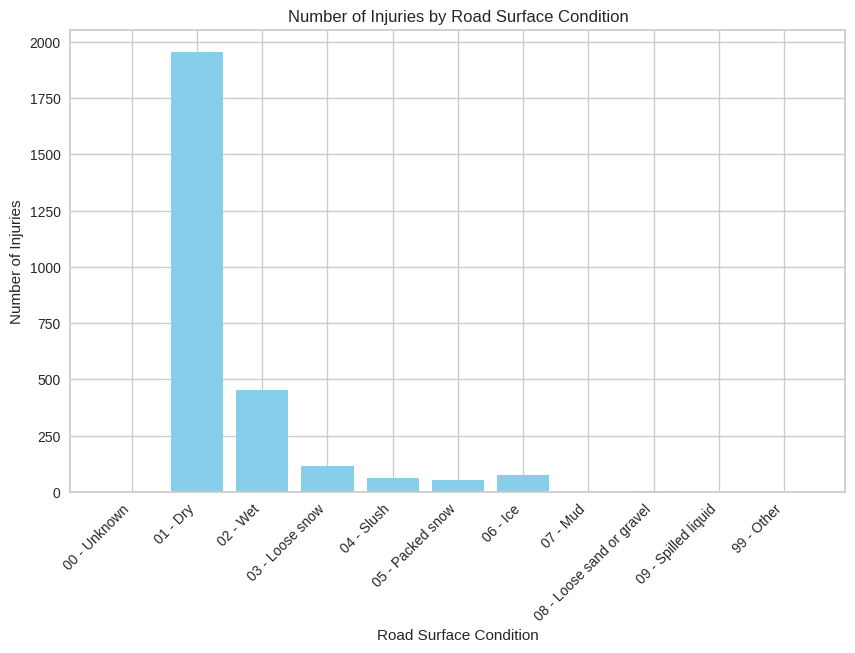

In [13]:
injuries_by_surface = df.groupby('Road_Surface_Condition')['Injured'].sum().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(injuries_by_surface['Road_Surface_Condition'], injuries_by_surface['Injured'], color='skyblue')
plt.title('Number of Injuries by Road Surface Condition')
plt.xlabel('Road Surface Condition')
plt.ylabel('Number of Injuries')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Analyzing injuries over time

Throughout the year, the number of injuries have remained in a constant range with few outliers on certain days. This means that the Accident_Date column can be dropped as it won't help in our predictions.

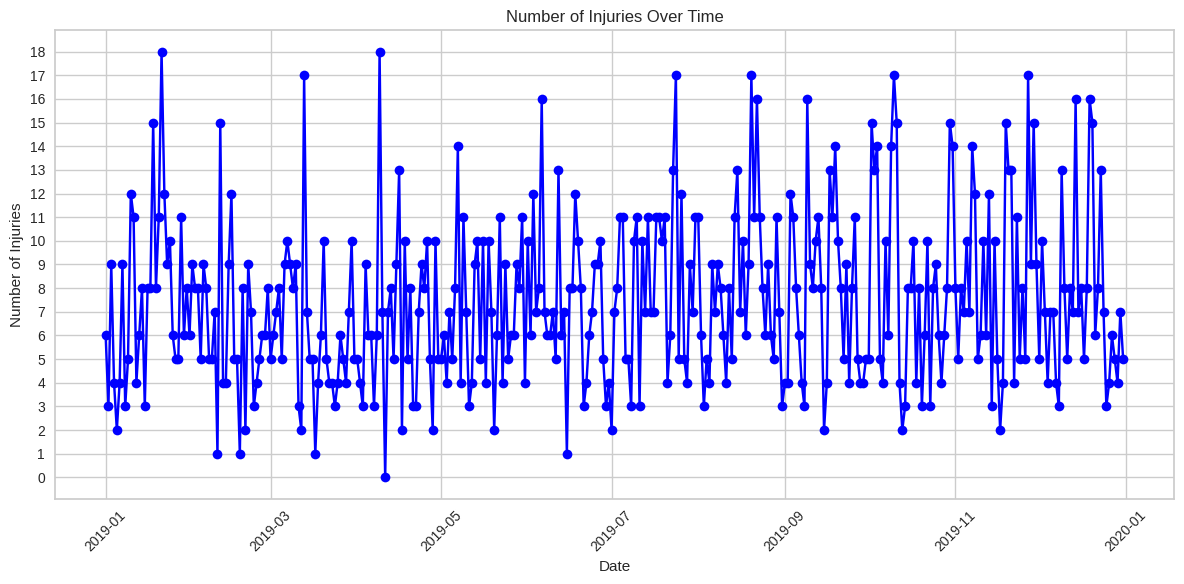

In [14]:
df['Accident_Date'] = pd.to_datetime(df['Accident_Date'])

# Group the data by 'Accident_Date' and sum the 'No__of_Injuries' for each date
injuries_by_date = df.groupby('Accident_Date')['Injured'].sum()
dates_with_more_than_14_injuries = injuries_by_date[injuries_by_date > 14]
# print(df[])
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(injuries_by_date.index, injuries_by_date.values, color='blue', marker='o', linestyle='-')
plt.title('Number of Injuries Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Injuries')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(range(0, max(injuries_by_date.values)+1))
plt.tight_layout()
plt.show()

Finally, we will also be dropping other ID columns like Anom_ID and ObjectId as they have no role in the prediction of the injuries. Also, we have dropped a few more non-numeric columns which are irrelavant to our prediction model.


In [15]:
df.drop(['Max_Injury', 'No__of_Minimal', 'No__of_Minor', 'No__of_Major', 'No__of_Fatal', 'Anom_ID','ObjectId','Accident_Date','Accident_Time','Location','Geo_ID'], axis=1, inplace=True)

# One Hot Encoding

Next, we will use One Hot Encoding to convert all categorical columns into numerical values before feeding it to train our machine learning models.

In [16]:
categorical_columns = ['Classification_of_Accident', 'Accident_Location', 'Initial_Impact_Type', 'Environment_Condition', 'Light',
                        'Road_Surface_Condition', 'Traffic_Control', 'Traffic_Control_Condition']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


# Correlation Matrix

Now, we will display the top ten correlated features to our target column from the updated dataframe.

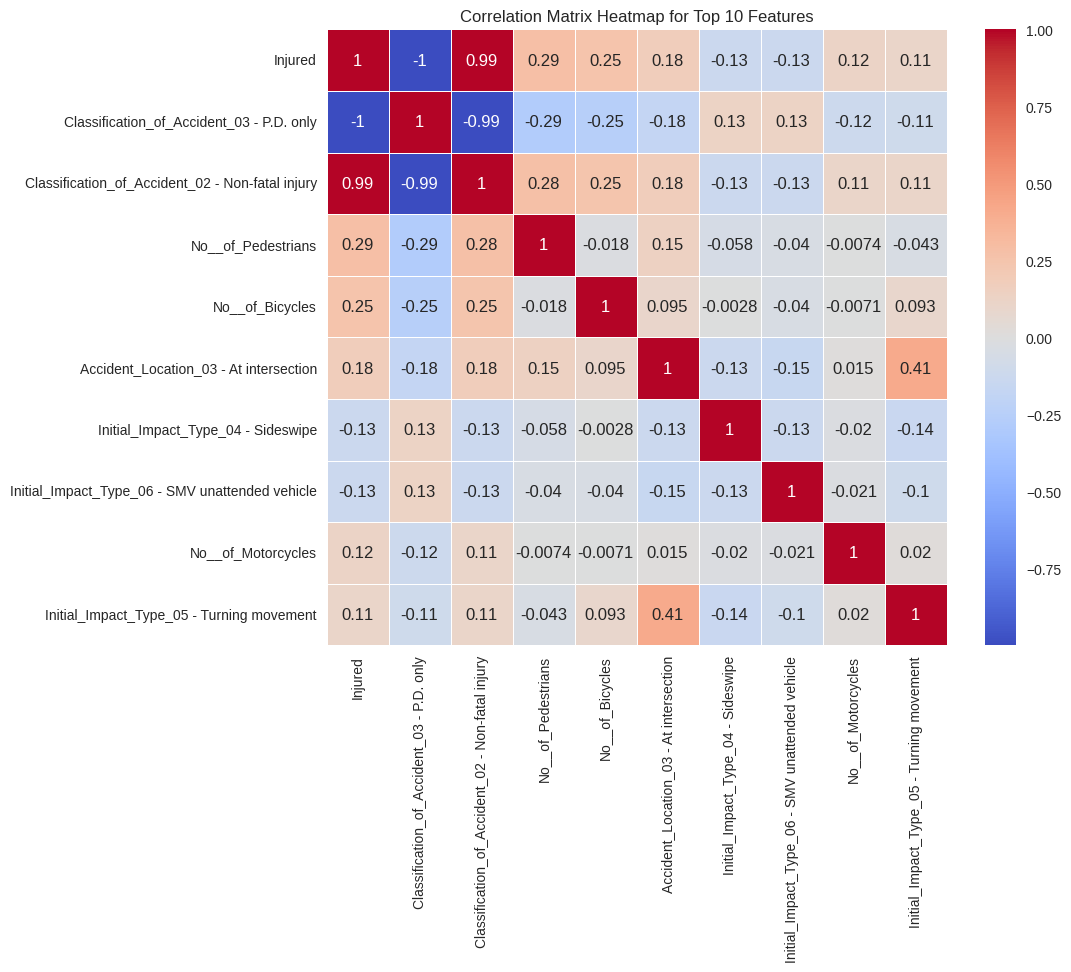

In [17]:
# Correlation Matrix
correlation_with_target = df.corr()['Injured'].abs()

top_features = correlation_with_target.sort_values(ascending=False).head(10).index

df_top_features = df[top_features]

correlation_matrix_top = df_top_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap for Top 10 Features')
plt.show()

# Dropping Classification_of_Accident  

As we can see from the above Confusion Matrix, the 'Classification_of_Accident' column has 100% correlation with the target variable. On further investigation of this column, it turned out that it has two unique values:

P.D. only (Property Damage only) which indirectly means that no injuries were involved.
Non-fatal injury: which means there were injuries involved.

Hence we will drop this column, as if we use this column to train our model, it will lead to 100% accuracy and our model's prediction will be biased on that one column.

In [18]:
df.drop(['Classification_of_Accident_02 - Non-fatal injury', 'Classification_of_Accident_03 - P.D. only'], axis=1, inplace=True)

In [19]:
df.columns

Index(['No__of_Vehicles', 'No__of_Bicycles', 'No__of_Motorcycles',
       'No__of_Pedestrians', 'X', 'Y', 'Latitude', 'Longitude', 'Injured',
       'Accident_Location_02 - Intersection related',
       'Accident_Location_03 - At intersection',
       'Accident_Location_04 - At/near private drive',
       'Accident_Location_05 - At railway crossing',
       'Accident_Location_06 - Underpass or tunnel',
       'Accident_Location_07 - Overpass or bridge',
       'Initial_Impact_Type_02 - Angle', 'Initial_Impact_Type_03 - Rear end',
       'Initial_Impact_Type_04 - Sideswipe',
       'Initial_Impact_Type_05 - Turning movement',
       'Initial_Impact_Type_06 - SMV unattended vehicle',
       'Initial_Impact_Type_07 - SMV other', 'Initial_Impact_Type_99 - Other',
       'Environment_Condition_01 - Clear', 'Environment_Condition_02 - Rain',
       'Environment_Condition_03 - Snow',
       'Environment_Condition_04 - Freezing Rain',
       'Environment_Condition_05 - Drifting Snow',
       '

# Exploratory Data Analysis

In [31]:
import folium

# Create a base map centered around Ottawa
ottawa_map = folium.Map(location=[45.4215, -75.6993], zoom_start=12)

# Add markers for each accident location
for index, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Injured']).add_to(ottawa_map)

# Save the map to an HTML file or display it
ottawa_map.save('ottawa_accidents_map.html')
# ottawa_map  # Uncomment this line if you want to display the map directly in a Jupyter notebook


In [ ]:
filtered_df = df[df['Accident_Date'].isin(dates_with_more_than_14_injuries.index)]

# Select the desired columns for tabulation
selected_columns = ['Accident_Date', 'No__of_Vehicles', 'No__of_Bicycles', 'No__of_Motorcycles', 'No__of_Pedestrians']

# Tabulate the selected data
tabulated_data = filtered_df[selected_columns]

# Print the tabulated data
print(tabulated_data)

In [ ]:
df.groupby('Road_Surface_Condition')['Injured'].sum()

In [ ]:
wet_condition_df = df[df['Road_Surface_Condition'] == '02 - Wet']

# Count the number of rows where 'No__of_Injuries' is zero and positive
zero_injuries_count = (wet_condition_df['No__of_Injuries'] == 0).sum()
positive_injuries_count = (wet_condition_df['No__of_Injuries'] > 0).sum()
print(zero_injuries_count, positive_injuries_count)

2336 452


In [ ]:

# Initialize lists to store the counts
conditions = []
zero_injuries_counts = []
positive_injuries_counts = []
ratio_counts = []
# Loop through each unique road surface condition
for condition in df['Road_Surface_Condition'].unique():
    # Filter the DataFrame for the current road surface condition
    condition_df = df[df['Road_Surface_Condition'] == condition]

    # Count the number of rows where 'No__of_Injuries' is zero and positive
    zero_injuries_count = (condition_df['No__of_Injuries'] == 0).sum()
    positive_injuries_count = (condition_df['No__of_Injuries'] > 0).sum()

    # Append the counts and condition to the lists
    conditions.append(condition)
    zero_injuries_counts.append(zero_injuries_count)
    positive_injuries_counts.append(positive_injuries_count)
    ratio_counts.append(positive_injuries_count/zero_injuries_count)

# Create a new DataFrame to store the tabular data
tabular_data = pd.DataFrame({
    'Road_Surface_Condition': conditions,
    'Zero_Injuries_Count': zero_injuries_counts,
    'Positive_Injuries_Count': positive_injuries_counts,
    'Ratio': ratio_counts
})

# Print the tabular data
print(tabular_data)

# Baseline Results

Now that we have our data ready, we will generate baseline results for KNN and Decision tree models.

First, we split the dataframe into input features (X), and output variable (y).
Then we scaled all the numerical values in the input feature vector to normalize the data and generalize the training process.

We will split the dataset further into train (70%) ,test (15%), and validation (15%) randomly sampled.

The shape of each vector shows the number of samples and number of columns present.

In [20]:
# Split the data into input features and target vectors
X = df.drop(columns=['Injured'])
y = df['Injured']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=69
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=69
)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(11479, 57)
(11479,)
(2460, 57)
(2460,)
(2460, 57)
(2460,)


# KNN Model Training

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate model
print("KNN Model:\n")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

knn_val_predictions = knn_model.predict(X_val)
print("\n\nValidation Set Results:\n")
print("Accuracy:", accuracy_score(y_val, knn_val_predictions))
print("Classification Report:\n", classification_report(y_val, knn_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, knn_val_predictions))


KNN Model:

Accuracy: 0.8239837398373984
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2033
           1       0.47      0.13      0.20       427

    accuracy                           0.82      2460
   macro avg       0.66      0.55      0.55      2460
weighted avg       0.78      0.82      0.78      2460

Confusion Matrix:
 [[1972   61]
 [ 372   55]]


Validation Set Results:

Accuracy: 0.841869918699187
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      2059
           1       0.54      0.18      0.27       401

    accuracy                           0.84      2460
   macro avg       0.70      0.58      0.59      2460
weighted avg       0.81      0.84      0.81      2460

Confusion Matrix:
 [[1998   61]
 [ 328   73]]


# Decision Tree Model Training

In [24]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate model
print("\nDecision Tree Model:\n")
print("Accuracy:\n", accuracy_score(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))

dt_val_predictions = dt_model.predict(X_val)
print("Validation Set Results:\n")
print("Accuracy:\n", accuracy_score(y_val, dt_val_predictions))
print("Classification Report:\n", classification_report(y_val, dt_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, dt_val_predictions))



Decision Tree Model:

Accuracy:
 0.8483739837398374
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      2033
           1       0.73      0.20      0.31       427

    accuracy                           0.85      2460
   macro avg       0.79      0.59      0.61      2460
weighted avg       0.83      0.85      0.81      2460

Confusion Matrix:
 [[2002   31]
 [ 342   85]]
Validation Set Results:

Accuracy:
 0.8617886178861789
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92      2059
           1       0.76      0.22      0.35       401

    accuracy                           0.86      2460
   macro avg       0.81      0.61      0.63      2460
weighted avg       0.85      0.86      0.83      2460

Confusion Matrix:
 [[2030   29]
 [ 311   90]]


We are getting 84% accuracy in validation set with KNN, and 86% in validation set with Decision Tree. This can be further improved with data augmentation techniques like SMOTE and feature selection techniques like SelectKBest, RFE, Dropping Non-Correlated Features, etc.

In [27]:
plt.figure(figsize=(400, 160))
plot_tree(dt_model, feature_names=df.columns, max_depth=2)
plt.show()

# SMOTE Analysis

In [28]:
# Oversampling
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

print(y.value_counts())


0    13678
1    13678
Name: Injured, dtype: int64


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=69
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=69
)

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate model
print("KNN Model:\n")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

knn_val_predictions = knn_model.predict(X_val)
print("\n\nValidation Set Results:\n")
print("Accuracy:", accuracy_score(y_val, knn_val_predictions))
print("Classification Report:\n", classification_report(y_val, knn_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, knn_val_predictions))

KNN Model:

Accuracy: 0.8817938094077504
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      2061
           1       0.92      0.84      0.88      2042

    accuracy                           0.88      4103
   macro avg       0.88      0.88      0.88      4103
weighted avg       0.88      0.88      0.88      4103

Confusion Matrix:
 [[1910  151]
 [ 334 1708]]


Validation Set Results:

Accuracy: 0.8798732943469786
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      2058
           1       0.92      0.83      0.87      2046

    accuracy                           0.88      4104
   macro avg       0.88      0.88      0.88      4104
weighted avg       0.88      0.88      0.88      4104

Confusion Matrix:
 [[1907  151]
 [ 342 1704]]


In [31]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate model
print("\nDecision Tree Model:\n")
print("Accuracy:\n", accuracy_score(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))

dt_val_predictions = dt_model.predict(X_val)
print("Validation Set Results:\n")
print("Accuracy:\n", accuracy_score(y_val, dt_val_predictions))
print("Classification Report:\n", classification_report(y_val, dt_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, dt_val_predictions))


Decision Tree Model:

Accuracy:
 0.8581525712893006
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      2061
           1       0.92      0.78      0.85      2042

    accuracy                           0.86      4103
   macro avg       0.87      0.86      0.86      4103
weighted avg       0.87      0.86      0.86      4103

Confusion Matrix:
 [[1927  134]
 [ 448 1594]]
Validation Set Results:

Accuracy:
 0.8662280701754386
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88      2058
           1       0.93      0.79      0.85      2046

    accuracy                           0.87      4104
   macro avg       0.88      0.87      0.87      4104
weighted avg       0.88      0.87      0.87      4104

Confusion Matrix:
 [[1945  113]
 [ 436 1610]]


After oversampling using SMOTE, the KNN Validation Accuracy has increased to 88%.

# KFold Cross Validation (Stratified) with GridSearchCV

We are using Stratified KFold with 5 splits for training along with performing GridSearch to find the best hyperparameters for our models.
For KNN, we get the best results with n_neighbours=9 and for Decision Tree we get the best scores with max_depth=10.


In [33]:
# KNN Classifier GridSearchCV
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
knn_grid.fit(X_train, y_train)
print("KNN Best Params: ", knn_grid.best_params_)
print("KNN Best Score: ", knn_grid.best_score_)

# Decision Tree Classifier GridSearchCV
dt_param_grid = {'max_depth': [None, 5, 10, 15]}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
dt_grid.fit(X_train, y_train)
print("DT Best Params: ", dt_grid.best_params_)
print("DT Best Score: ", dt_grid.best_score_)

# K-Fold Cross-Validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
knn_auc_scores = cross_val_score(knn, X_train, y_train, cv=k_fold, scoring='roc_auc')#'roc_auc')

# Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'], random_state=42)
dt.fit(X_train, y_train)
dt_auc_scores = cross_val_score(dt, X_train, y_train, cv=k_fold, scoring='roc_auc')

# Print AUC scores
print("KNN AUC Scores:", knn_auc_scores)
print("Decision Tree AUC Scores:", dt_auc_scores)

KNN Best Params:  {'n_neighbors': 9}
KNN Best Score:  0.9294343844141097
DT Best Params:  {'max_depth': 10}
DT Best Score:  0.9144273602117178
KNN AUC Scores: [0.93455744 0.92627814 0.92821721 0.9300693  0.93252977]
Decision Tree AUC Scores: [0.91792602 0.90142181 0.91030089 0.916844   0.92479711]


# ROC AUC Curves

The KNN model has higher ROC AUC Scores for validation and test sets, indicating that it is better at predicting injured and non-injured classes compared to the Decision Tree Model.

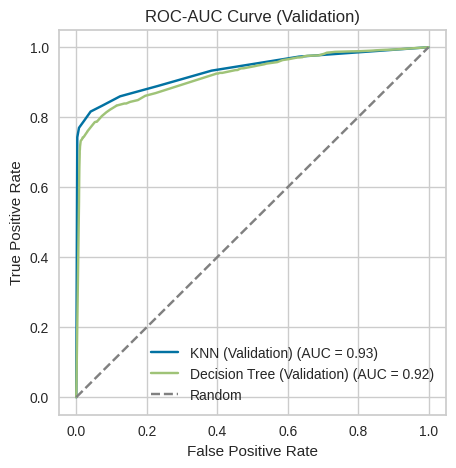

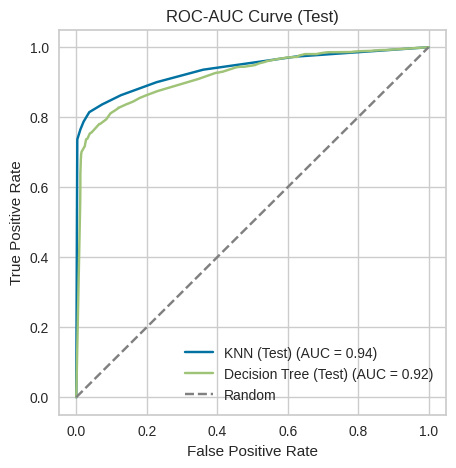

In [34]:
# Plot ROC-AUC curves
def plot_roc_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Predictions on the validation set
y_prob_knn_val = knn.predict_proba(X_val)[:, 1]
y_prob_dt_val = dt.predict_proba(X_val)[:, 1]

# Plot ROC-AUC curves for the validation set
plt.figure(figsize=(5, 5))
plot_roc_curve(y_val, y_prob_knn_val, label='KNN (Validation)')
plot_roc_curve(y_val, y_prob_dt_val, label='Decision Tree (Validation)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.title('ROC-AUC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Predictions on the test set
y_prob_knn_test = knn.predict_proba(X_test)[:, 1]
y_prob_dt_test = dt.predict_proba(X_test)[:, 1]

# Plot ROC-AUC curves for the test set
plt.figure(figsize=(5, 5))
plot_roc_curve(y_test, y_prob_knn_test, label='KNN (Test)')
plot_roc_curve(y_test, y_prob_dt_test, label='Decision Tree (Test)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.title('ROC-AUC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# Using Top K Correlated Features

We will try a few more Feature Selection Techniques to try and improve the accuracy of the model.

In [44]:
# print(df.info())

correlation_with_target = df.corr()['Injured'].abs()

top_features = correlation_with_target.sort_values(ascending=False).head(50).index

df_top_features = df[top_features]

# Taking top 10 features
y = df_top_features['Injured']
X = df_top_features.drop(labels=['Injured'], axis=1)

print(y.value_counts())


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(y.value_counts())

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=69
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=69
)

knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate model
print("\nKNN Model:\n")
print("Test Set Results:\n")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

knn_val_predictions = knn_model.predict(X_val)
print("\nValidation Set Results:\n")
print("Accuracy:", accuracy_score(y_val, knn_val_predictions))
print("Classification Report:\n", classification_report(y_val, knn_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, knn_val_predictions))


# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate model
print("\n\nDecision Tree Model:\n")
print("\nTest Set Results:\n")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))

dt_val_predictions = dt_model.predict(X_val)
print("\nValidation Set Results:\n")
print("Accuracy:", accuracy_score(y_val, dt_val_predictions))
print("Classification Report:\n", classification_report(y_val, dt_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, dt_val_predictions))


0    13678
1     2721
Name: Injured, dtype: int64
0    13678
1    13678
Name: Injured, dtype: int64

KNN Model:

Test Set Results:

Accuracy: 0.8737509139653912
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      2061
           1       0.90      0.84      0.87      2042

    accuracy                           0.87      4103
   macro avg       0.88      0.87      0.87      4103
weighted avg       0.88      0.87      0.87      4103

Confusion Matrix:
 [[1875  186]
 [ 332 1710]]

Validation Set Results:

Accuracy: 0.8620857699805068
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2058
           1       0.89      0.82      0.86      2046

    accuracy                           0.86      4104
   macro avg       0.86      0.86      0.86      4104
weighted avg       0.86      0.86      0.86      4104

Confusion Matrix:
 [[1854  204]
 [ 3

# Select K Best

In [47]:
select = SelectKBest(score_func=chi2, k=48)
Z = select.fit_transform(X_scaled,y)

X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=69)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=69)

# KNN Model
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate model
print("\nKNN Model:\n")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

knn_val_predictions = knn_model.predict(X_val)
print("\n\nValidation Set Results:\n")
print("Accuracy:", accuracy_score(y_val, knn_val_predictions))
print("Classification Report:\n", classification_report(y_val, knn_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, knn_val_predictions))

# Decision Tree Model
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate model
print("\n\nDecision Tree Model:\n")
print("Accuracy:\n", accuracy_score(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))

dt_val_predictions = dt_model.predict(X_val)
print("Validation Set Results:\n")
print("Accuracy:\n", accuracy_score(y_val, dt_val_predictions))
print("Classification Report:\n", classification_report(y_val, dt_val_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, dt_val_predictions))


KNN Model:

Accuracy: 0.8737509139653912
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      2061
           1       0.90      0.84      0.87      2042

    accuracy                           0.87      4103
   macro avg       0.88      0.87      0.87      4103
weighted avg       0.88      0.87      0.87      4103

Confusion Matrix:
 [[1875  186]
 [ 332 1710]]


Validation Set Results:

Accuracy: 0.8620857699805068
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2058
           1       0.89      0.82      0.86      2046

    accuracy                           0.86      4104
   macro avg       0.86      0.86      0.86      4104
weighted avg       0.86      0.86      0.86      4104

Confusion Matrix:
 [[1854  204]
 [ 362 1684]]


Decision Tree Model:

Accuracy:
 0.8488910553253717
Classification Report:
               precision    rec

In [48]:
knn_auc_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='roc_auc')#'roc_auc')
knn_auc_scores

array([0.92565137, 0.91609616, 0.91667017, 0.92117576, 0.92799003])

In [49]:
dt_auc_scores = cross_val_score(dt_model, X_train, y_train, cv=k_fold, scoring='roc_auc')#'roc_auc')
dt_auc_scores

array([0.90243048, 0.89746595, 0.90240185, 0.90412823, 0.91624446])